In [1]:
import os
import re
import sys
import json
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt

sys.path.append('../..')

from src.melody import Melody
from src.utils import notes_to_midi, notes_and_chord_to_midi, get_chord_progressions, replace_enharmonic

rcParams['figure.figsize'] = 20,10

In [2]:
folder = f'../../data/finalised/csv'
filepaths = [y for x in os.walk(folder) for y in glob(os.path.join(x[0], '*.csv'))]

chord_progressions = get_chord_progressions('../..')

len(filepaths)

497

In [3]:
metrics = {}

all_dfs = []

for filepath in filepaths:
    song_name = os.path.basename(filepath).replace('.csv', '')
    song_name = "".join(song_name.split(' - ')[-1])
    song_name = re.sub('\(.*\)', '', song_name).strip()
    song_name = re.sub('-[0-9]*[0-9]-', '', song_name)
    song_name = re.sub('-o-', '', song_name)
    
    original = 'Real Book' in filepath

    df = pd.read_csv(filepath, index_col=0)
    
    df['filename'] = filepath
    df['song'] = song_name
    df['original'] = original
    
    all_dfs.append(df)
    

total_df = pd.concat(all_dfs)  

pitch_classes = ['C','Db','D','Eb','E','F','F#','G', 'Ab', 'A', 'Bb', 'B']
total_df['pitch_class'] = (total_df['pitch'] % 12).apply([lambda x: pitch_classes[x]])
total_df['source'] = total_df['filename'].apply([lambda x: os.path.basename(os.path.dirname(x))])

In [4]:
total_df.columns

Index(['pitch', 'pitch_class', 'time', 'raw_ticks', 'quant_ticks',
       'raw_duration', 'quant_duration', 'offset', 'measure', 'ticks',
       'duration', 'chord_name', 'filename', 'song', 'original', 'Unnamed: 0',
       'source'],
      dtype='object')

In [5]:
o = total_df[total_df['original'] == True]
i = total_df[total_df['original'] == False]

[Text(0.5, 0, 'n. of measures'), Text(0, 0.5, 'n. of examples')]

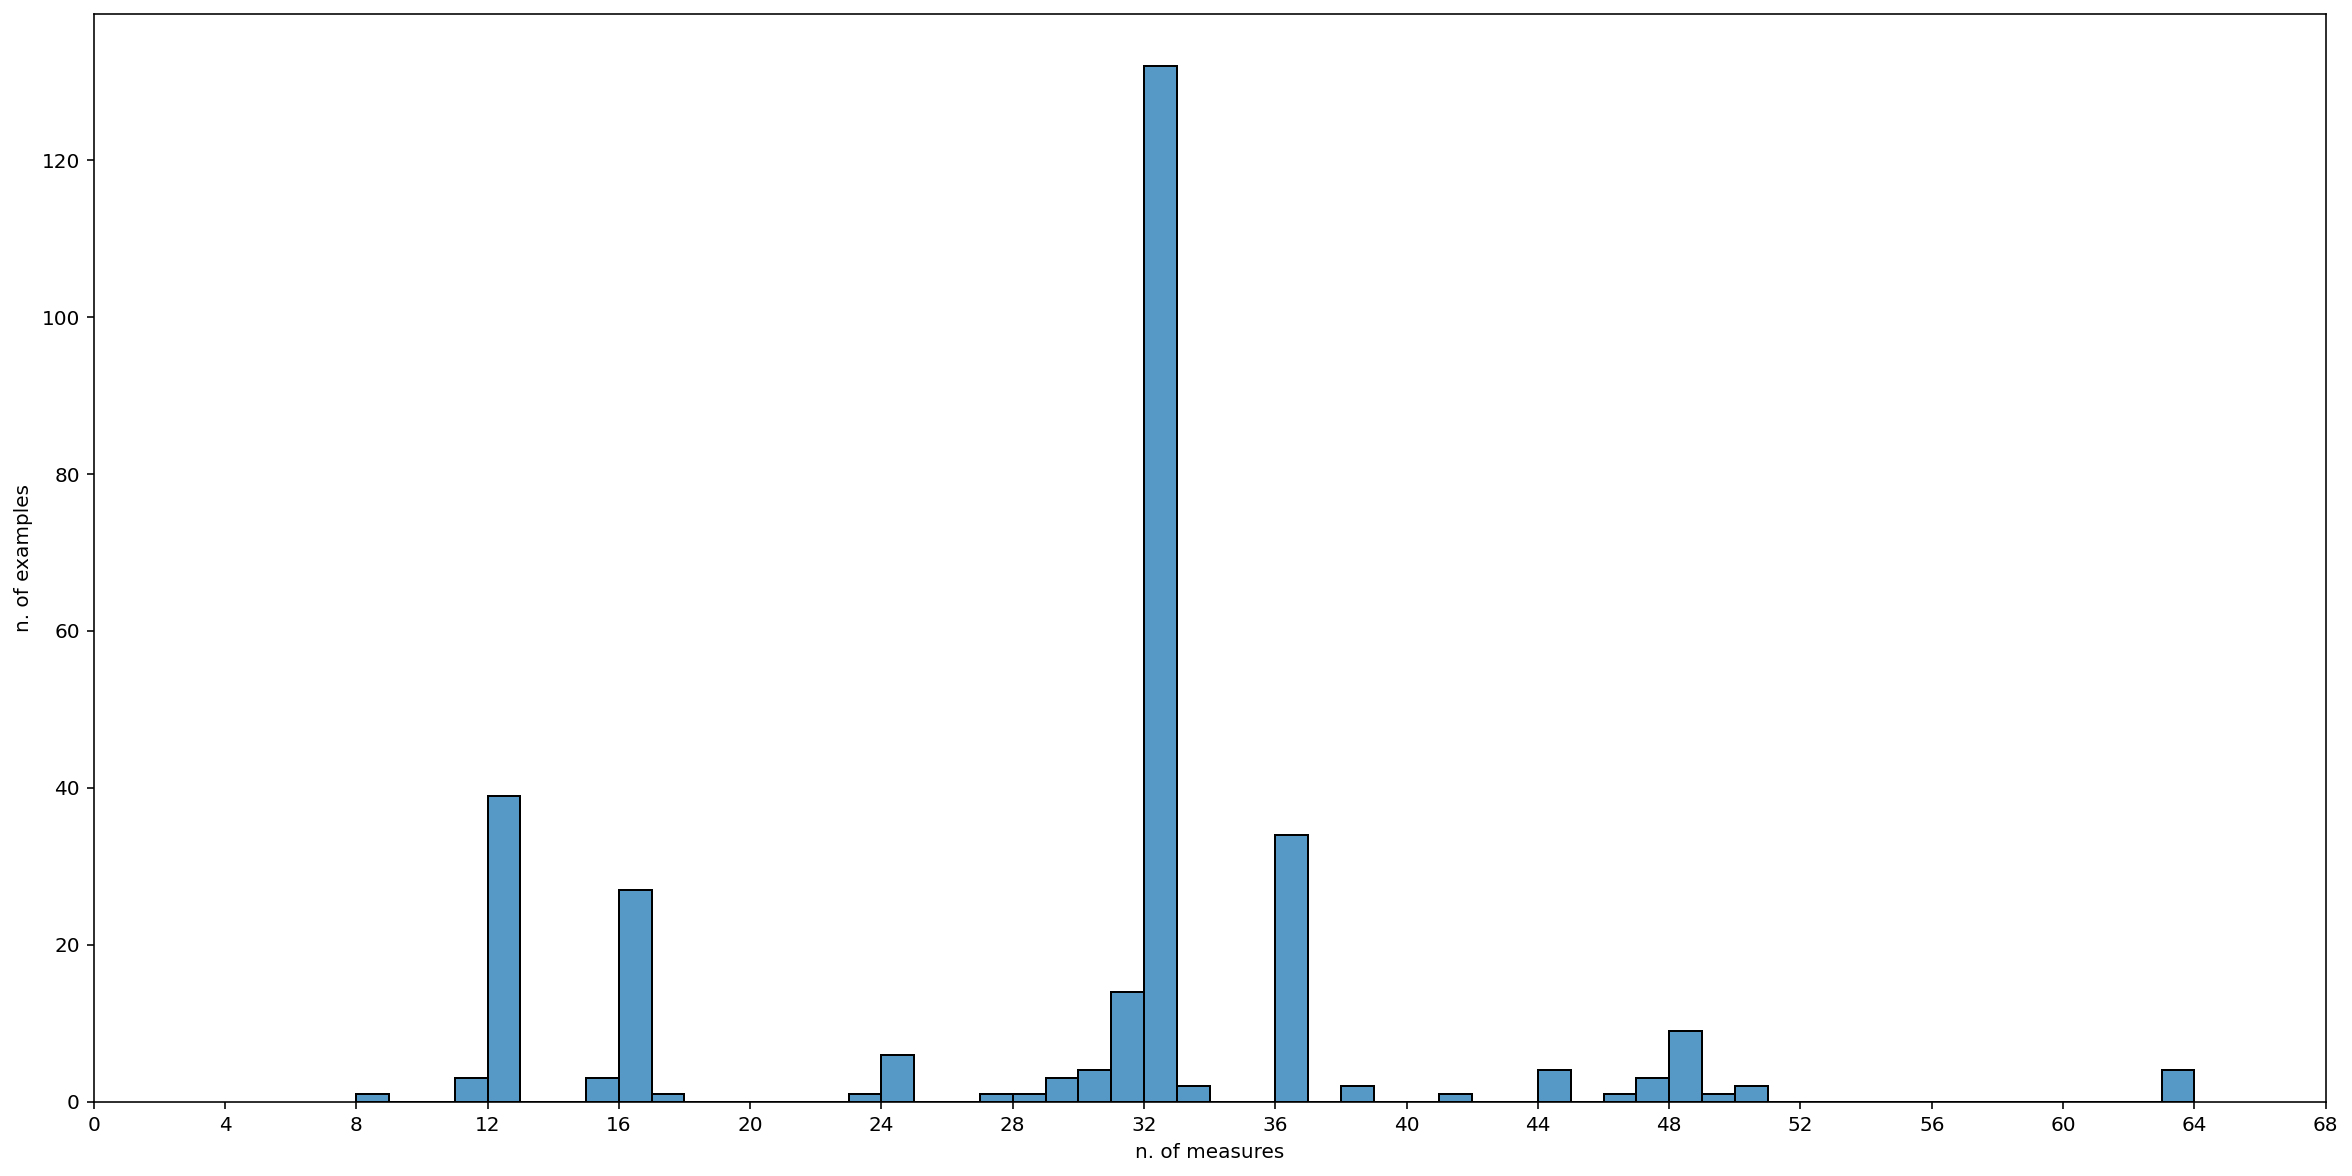

In [31]:
data = i.groupby('filename')['measure'].apply(max) + 1
ax = sns.histplot(i.groupby('filename')['measure'].apply(max) + 1, kde=False, bins=np.arange(data.min(), data.max() + 1))
ax.set(xticks=np.arange(0,71,4))
ax.set(xlabel='n. of measures', ylabel='n. of examples')

[Text(0.5, 0, 'n. of notes'), Text(0, 0.5, 'n. of examples')]

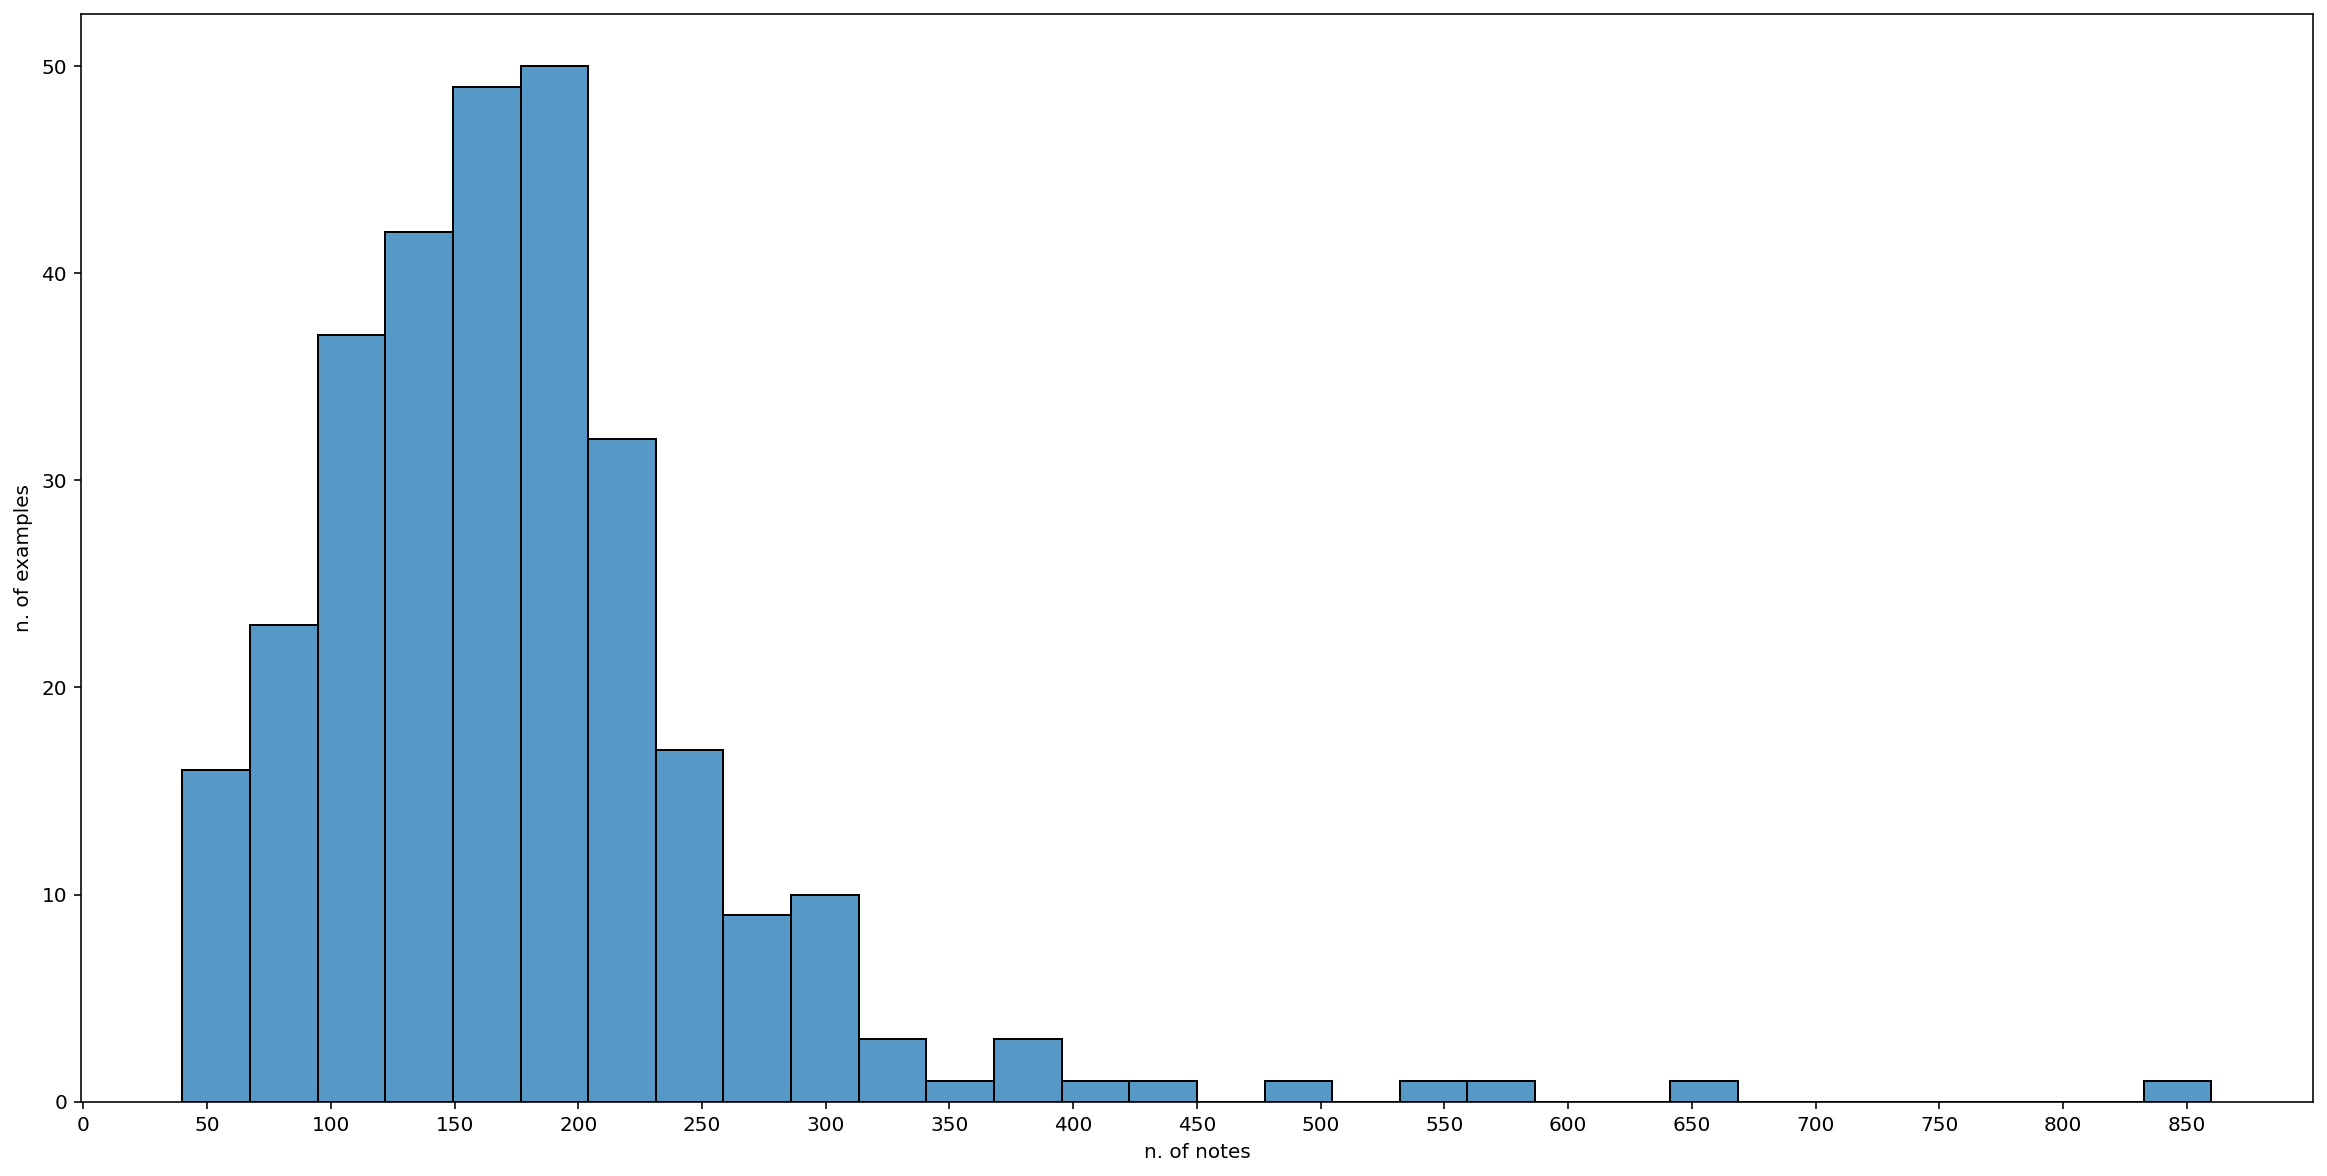

In [36]:
data = i.groupby('filename').apply(len)
ax = sns.histplot(data)
ax.set(xticks=np.arange(0,900,50))
ax.set(xlabel='n. of notes', ylabel='n. of examples')
# plt.axvline(x=data.mean(), color='blue')
# plt.axvline(x=data.mean()-data.std(), color='green')
# plt.axvline(x=data.mean()+data.std(), color='green')

/home/manu/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'duration'), Text(0, 0.5, 'n. of notes')]

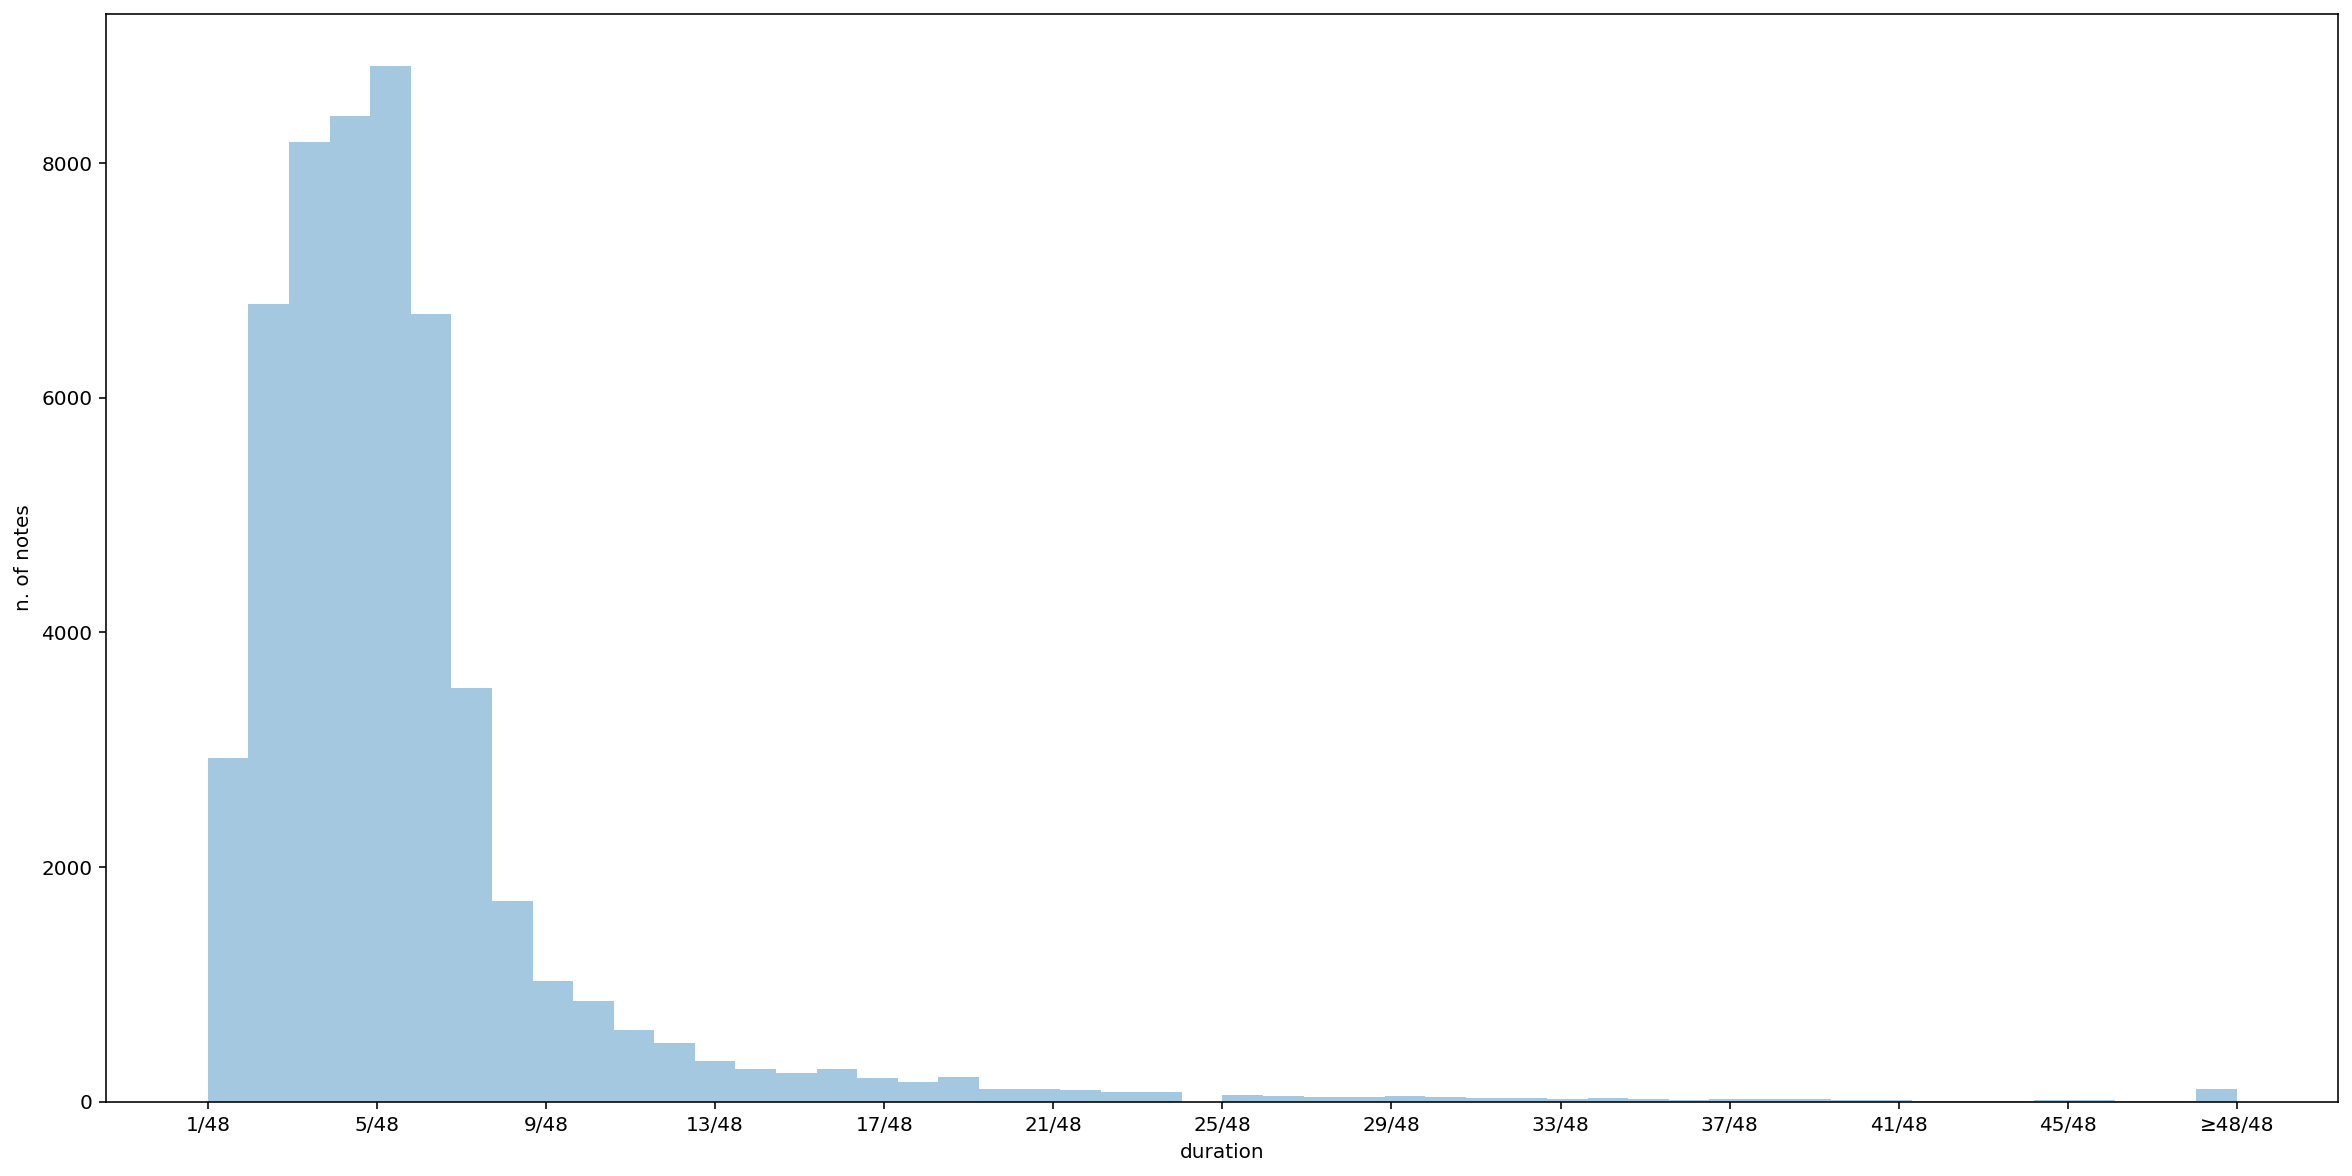

In [35]:
data = i['duration'].apply(lambda x: x if x <= 48 else 49)

ax = sns.distplot(data, kde=False)
ax.set(xticks=np.append(np.arange(1, 49, 4), 49), 
       xticklabels=[f'{a}/48' for a in np.arange(1, 49, 4)] + ['≥48/48'])
ax.set(xlabel='duration', ylabel='n. of notes')

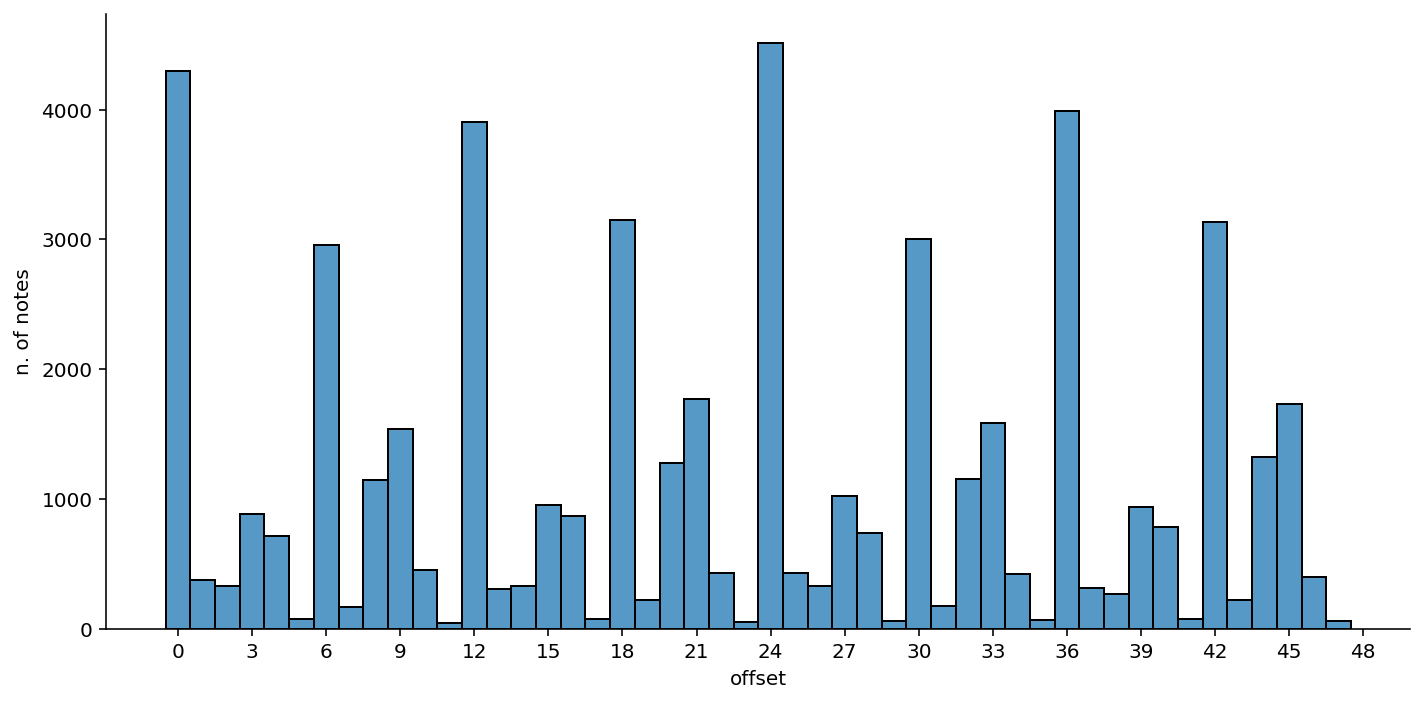

In [9]:
ax = sns.displot(data=i['offset'],
                height=5,
                aspect=2,
                kde=False,
                discrete=True,
                rug=False)
ax.set(xticks=np.arange(0,49,3))
ax.set(xlabel='offset', ylabel='n. of notes')

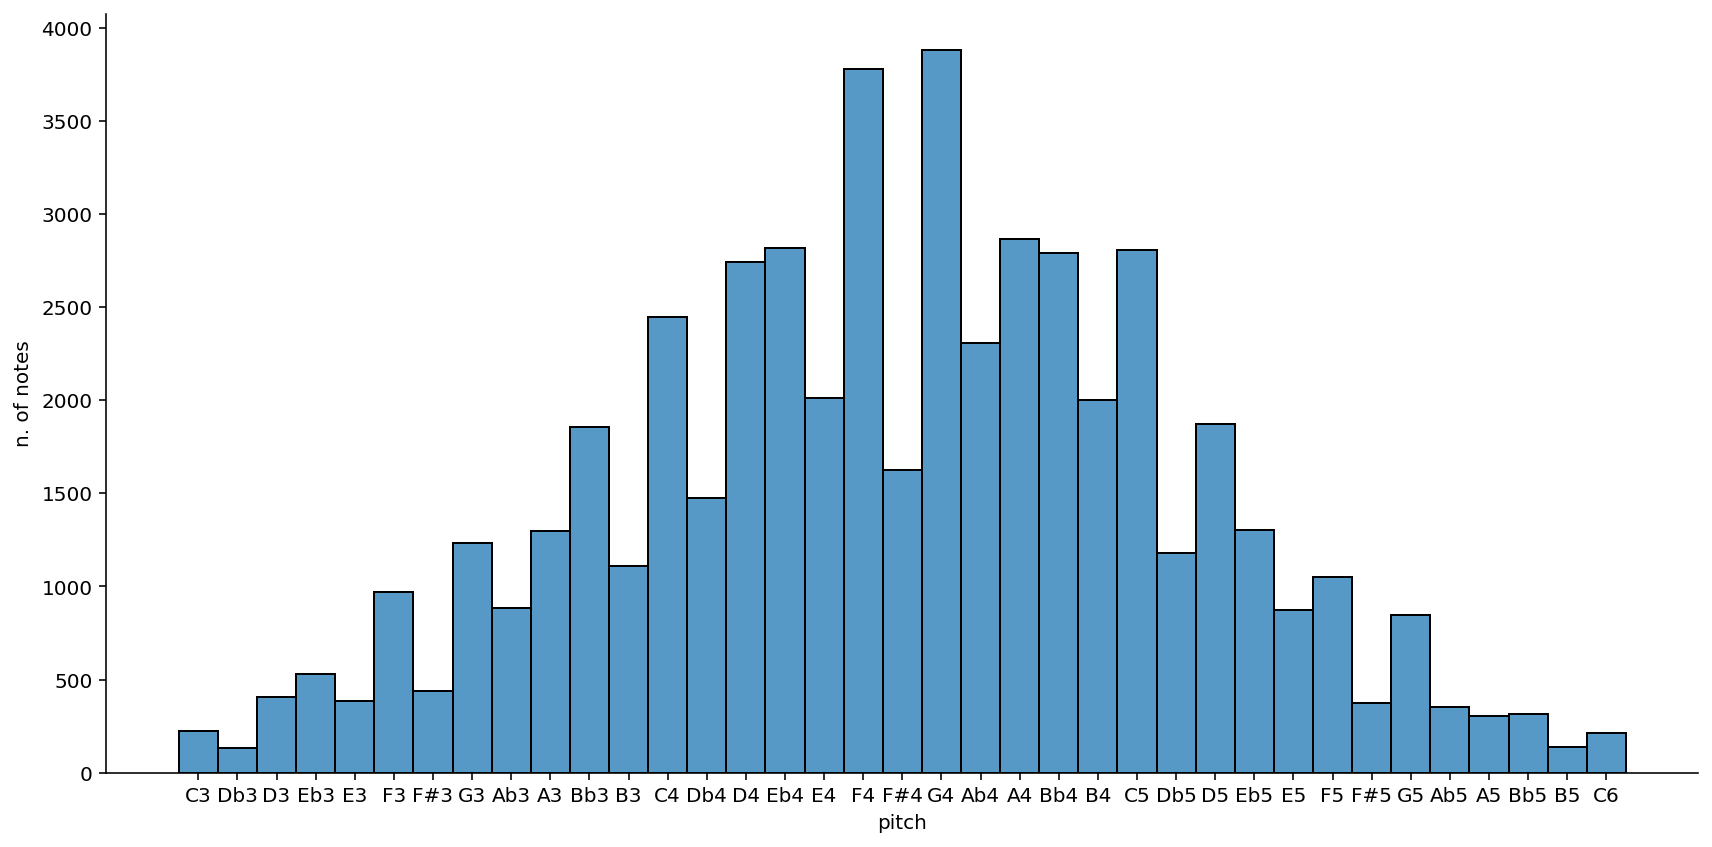

In [10]:
min_p = 48
max_p = 84
r = range(min_p, max_p+1) 
labels = [f'{pitch_classes[p%12]}{(p//12)-1}' for p in r]
data = i[(i['pitch']<=max_p) & (i['pitch']>=min_p)]['pitch']

ax = sns.displot(data=data,
                height=6,
                aspect=2,
                kde=False,
                discrete=True,
                rug=False)
ax.set(xticks=np.arange(min_p,max_p+1, 1), xticklabels=labels)
ax.set(xlabel='pitch', ylabel='n. of notes')

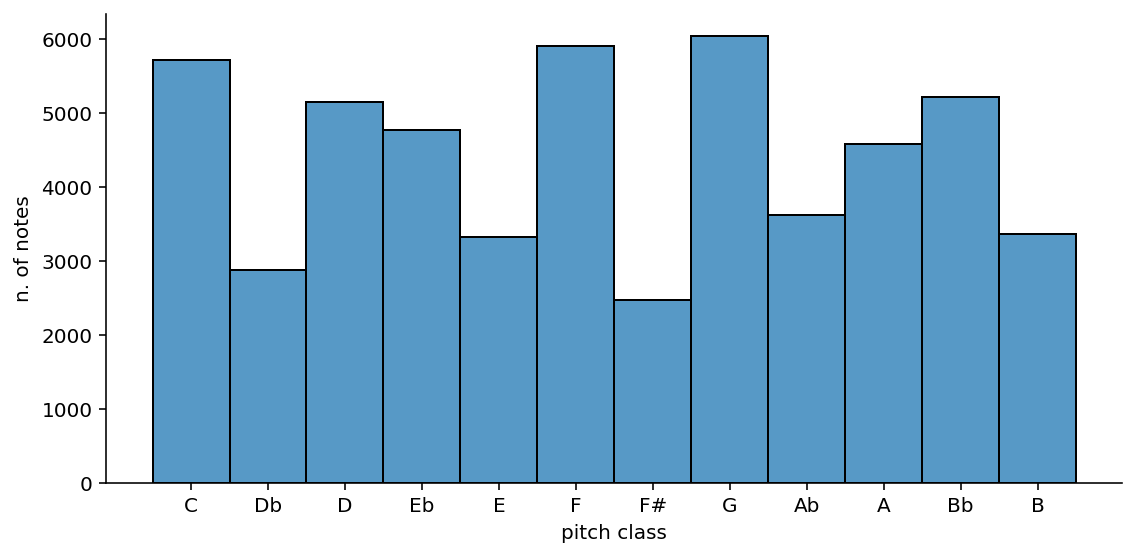

In [11]:
ax = sns.displot(data=i['pitch_class'].astype("category").cat.set_categories(pitch_classes),
                height=4,
                aspect=2,
                kde=False,
                discrete=True,
                rug=False)
ax.set(xlabel='pitch class', ylabel='n. of notes')

In [12]:
# sns.countplot(total_df[total_df['original'] == False].groupby('song')['filename'].unique().apply(len))

In [13]:
import ast
import music21
from src.utils.ezchord import Chord
import mingus.core.notes as notes

context  = music21.key.Key('C')

i['chord_notes'] = i['chord_name'].apply([lambda x: [notes.int_to_note(y % 12, 'b') for y in Chord(x).getMIDI()]])
i['chord_root'] =  i['chord_notes'].apply([lambda x: x[0]])
i['chord_notes_triads'] = i['chord_notes'].apply([lambda x: x[1:4]])

chord_map = {}

for uc in i['chord_notes_triads'].drop_duplicates():
    suc = str(uc)
    chord_map[suc] = music21.chord.Chord(uc).simplifyEnharmonics().pitchedCommonName
        
i['chord_notes_triad_names'] = i['chord_notes_triads'].apply([lambda x: chord_map[str(x)]])
i['chord_notes_triad_names'] = i['chord_notes_triad_names'].str.replace('triad', '').str.replace('-', ' ').str.replace('major', 'maj').str.replace('minor', 'min')

/tmp/ipykernel_1873670/1450480526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['chord_notes'] = i['chord_name'].apply([lambda x: [notes.int_to_note(y % 12, 'b') for y in Chord(x).getMIDI()]])
/tmp/ipykernel_1873670/1450480526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['chord_root'] =  i['chord_notes'].apply([lambda x: x[0]])
/tmp/ipykernel_1873670/1450480526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [14]:
# sns.countplot(data=total_df, x='chord_root', order=total_df['chord_root'].value_counts().index)

In [15]:
i['chord_name'].nunique()

184

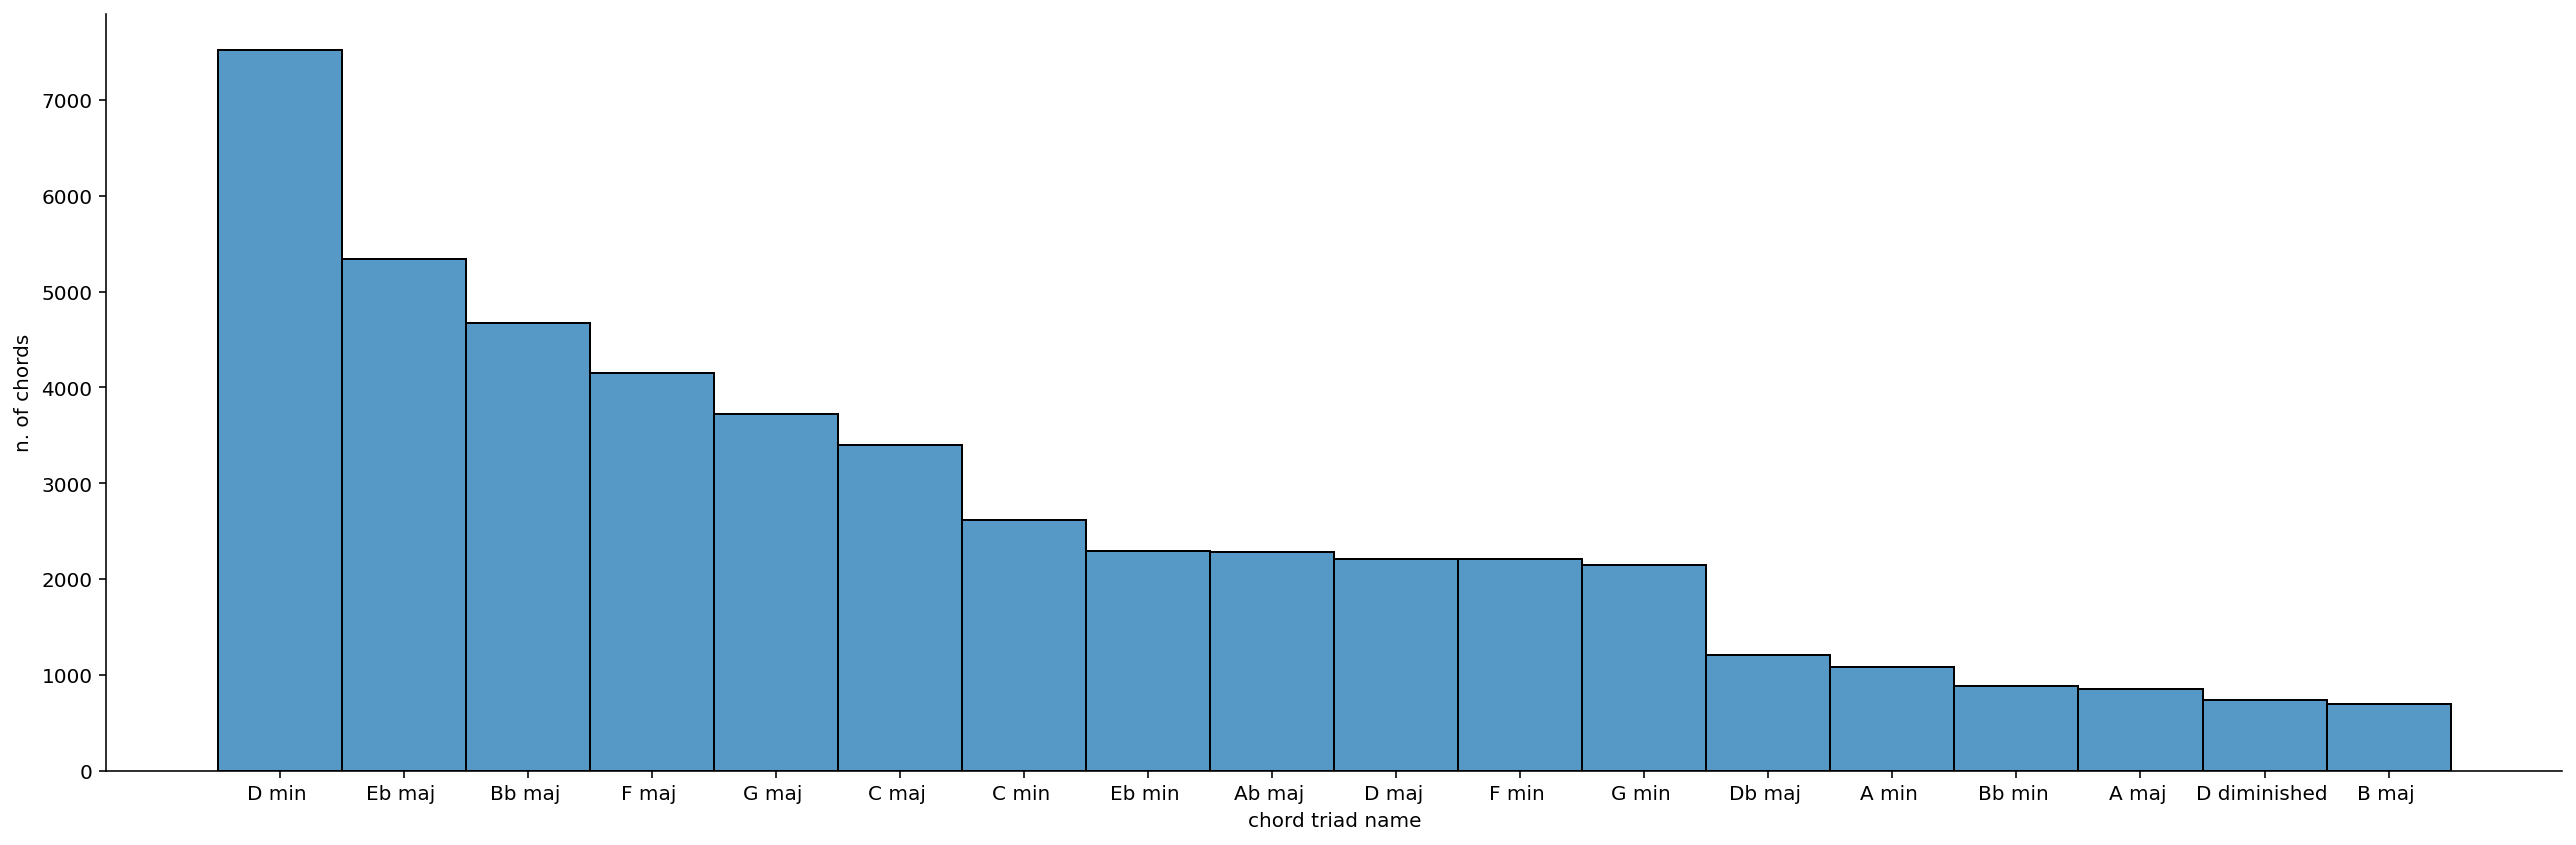

In [16]:
sorter = i['chord_notes_triad_names'].value_counts(ascending=False).index.values[:18]


ax = sns.displot(i['chord_notes_triad_names'].astype("category").cat.set_categories(sorter), 
                 height=6,
                 aspect=3,
                 kde=False,
                 discrete=True,
                 rug=False
#                order=total_df['chord_notes_triad_names'].value_counts().iloc[:20].index
                )
ax.set(xlabel='chord triad name', ylabel='n. of chords')

In [17]:
i['chord_notes_triad_names'].value_counts(ascending=False)[:6]

D min      7527
Eb maj     5337
Bb maj     4673
F maj      4155
G maj      3727
C maj      3396
Name: chord_notes_triad_names, dtype: int64

In [18]:
i['chord_notes_triad_names'].value_counts(ascending=False)[6:].sum()

24181

In [19]:
stats = {}

for filepath in filepaths:
    melody = Melody(filepath)
    melody.setup()
    melody.set_song_structure(chord_progressions[melody.song_name])
    
    key = music21.key.Key(melody.chord_progression_key, "minor" if melody.chord_progression_minor else 'major')
    if key.mode == 'minor':
        key = key.relative
    
    stats[melody.filepath] = {
        'key': key
    }

s = pd.DataFrame().from_dict(stats).T
s['key_root'] = s['key'].apply(lambda x: x.tonic)
s['key_mode'] = s['key'].apply(lambda x: x.mode)
s['key_name'] = s['key'].apply(lambda x: replace_enharmonic(x.tonic.name.replace('-', 'b')))

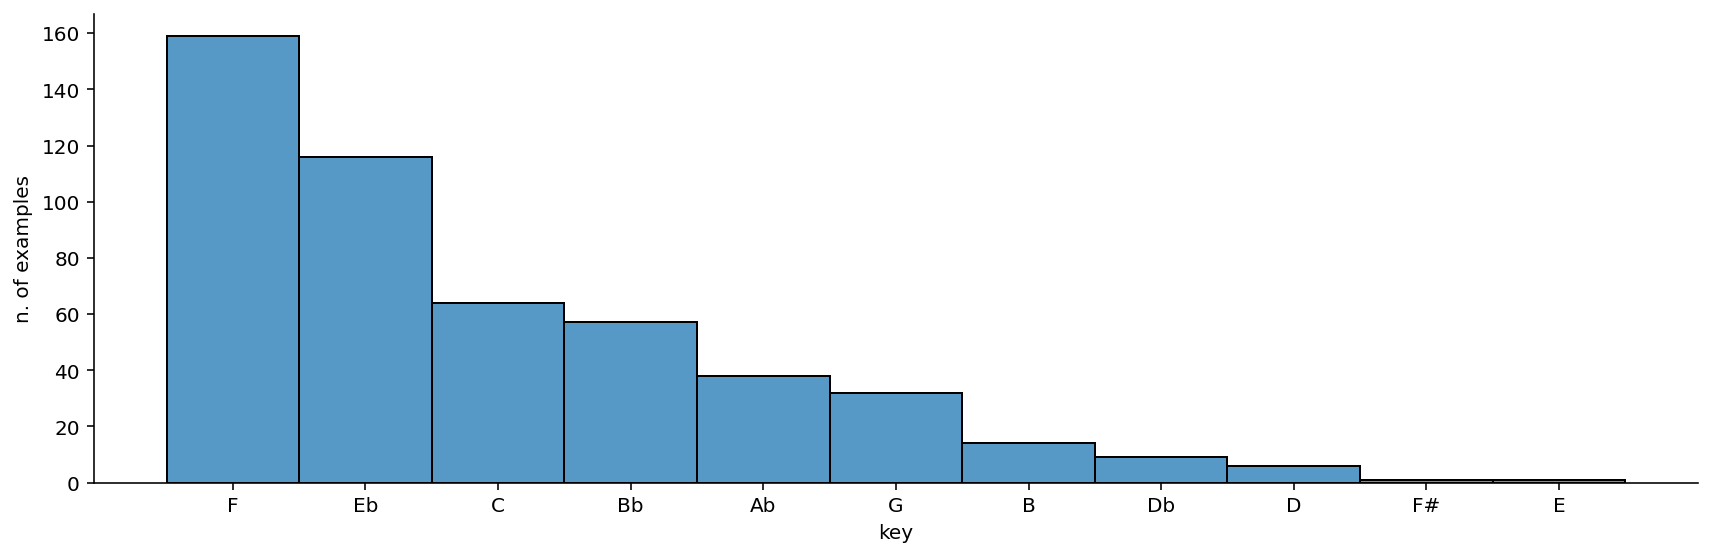

In [20]:
sorter = s['key_name'].value_counts(ascending=False).index.values

ax = sns.displot(s['key_name'].astype("category").cat.set_categories(sorter),
                 height=4,
                 aspect=3,
                 kde=False,
                 discrete=True,
                 rug=False
                )
ax.set(xlabel='key', ylabel='n. of examples')

In [21]:
100 * s['key_name'].value_counts(ascending=False)[6:].sum() / s['key_name'].value_counts(ascending=False)[:6].sum() 

6.652360515021459

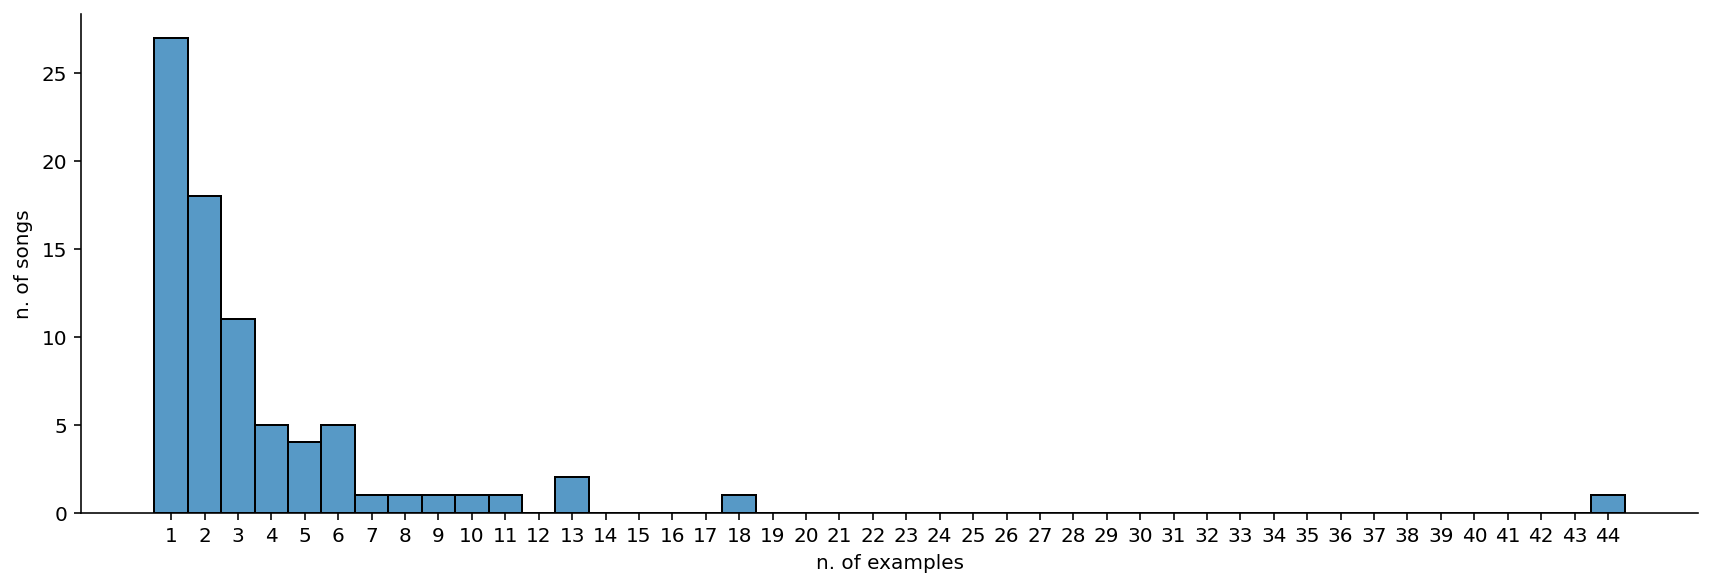

In [22]:
ax = sns.displot(
     i.groupby('song').apply(lambda x: x['filename'].nunique()),
     height=4,
     aspect=3,
     kde=False,
     discrete=True,
     rug=False
)
ax.set(xticks=np.arange(1,45,1))
ax.set(xlabel='n. of examples', ylabel='n. of songs')

In [23]:
i.groupby('song').apply(lambda x: x['filename'].nunique()).sort_values().tail(20)

song
Alone Together                      4
Summertime                          4
I'll Remember April                 5
Just Friends                        5
Bessie's Blues                      5
Bemsha Swing                        5
Airegin                             6
Yesterdays                          6
Oleo                                6
So What                             6
My Funny Valentine                  6
Secret Love                         7
Esp                                 8
Anthropology                        9
Softly As In A Morning Sunrise     10
All The Things You Are             11
Eighty-One                         13
Giant Steps                        13
Blue Train                         18
Impressions                        44
dtype: int64